In [1]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print('Работаете в другой среде')

Работаете в другой среде


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

!pip install catboost
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from tqdm.autonotebook import tqdm
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

/var/folders/lz/wsqs45rs6qq8p9wm901mkyyc0000gn/T/ipykernel_13028/1232119039.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
try:
    df = pd.read_csv('/content/gdrive/MyDrive/loan.csv')
except:
    df = pd.read_csv('/Users/nataliia/Desktop/archive/loan/loan.csv')

/var/folders/lz/wsqs45rs6qq8p9wm901mkyyc0000gn/T/ipykernel_13028/1795298819.py:4: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/nataliia/Desktop/archive/loan/loan.csv')


In [4]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           887379 non-null  int64  
 1   member_id                    887379 non-null  int64  
 2   loan_amnt                    887379 non-null  float64
 3   funded_amnt                  887379 non-null  float64
 4   funded_amnt_inv              887379 non-null  float64
 5   term                         887379 non-null  object 
 6   int_rate                     887379 non-null  float64
 7   installment                  887379 non-null  float64
 8   grade                        887379 non-null  object 
 9   sub_grade                    887379 non-null  object 
 10  emp_title                    835917 non-null  object 
 11  emp_length                   842554 non-null  object 
 12  home_ownership               887379 non-null  object 
 13 

- loan_grade - Кредитный рейтинг, присвоенный LC
- installment - частичный взнос
- emp_title - профессия
- emp_length - Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
- annual_inc - годовой доход
- verification_status - Indicates if the co-borrowers' joint income was verified by LC, not verified, or if the income source was verified
- issue_d - дата заема - **подумать**
- loan_status - **target** (надо определиться, что считаем за риск)
- pymnt_plan - Указывает, был ли введен в действие план платежей по кредиту
- url -  **удаляем**
- **desc** - можно заполнить 1 - есть описание, 0 - нет
- purpose - цель
- title - можно выделить много всего интересного (например по слову job можно найти предположительно тех, у кого проблемы с работой)
- zip_code - **удаляем**
- addr_state - **удаляем**
- dti - предельная долговая нагрузка. Соотношение, рассчитанное с использованием общих ежемесячных платежей заемщика по долгу к общей сумме долговых обязательств, за исключением ипотеки и запрашиваемого кредита LC, деленное на ежемесячный доход заемщика, о котором он сам сообщил.
- delinq_2yrs - Количество просроченных платежей более чем на 30 дней в кредитном досье заемщика за последние 2 года
- earliest_cr_line - Месяц, в котором была открыта самая ранняя заявленная заемщиком кредитная линия - **заменить на 1, 2 и тд**
- inq_last_6mths - Количество запросов за последние 6 месяцев (без учета запросов на авто и ипотеку)
- mths_since_last_delinq - Количество месяцев, прошедших с момента последней просрочки заемщиком.
- mths_since_last_record - **удаляем** непонятная вещь
- open_acc - Количество открытых кредитных линий в кредитном досье заемщика
- pub_rec - Количество уничижительных публичных записей **?**
- revol_bal - Общий возобновляемый остаток по кредиту
- revol_util - Коэффициент использования возобновляемой линии, или сумма кредита, которую использует заемщик, по отношению ко всем доступным возобновляемым кредитам.
- total_acc - Общее количество кредитных линий, имеющихся в настоящее время в кредитном досье заемщика
- initial_list_status - Первоначальный статус перечисления займа. Возможные значения – W, F
- out_prncp - Оставшийся непогашенным основной долг на общую сумму финансирования
- out_prncp_inv- Оставшийся непогашенным основной долг за часть общей суммы, профинансированной инвесторами
- total_pymnt - Платежи, полученные на сегодняшний день на общую сумму финансирования
- total_pymnt_inv - Платежи, полученные на сегодняшний день за часть общей суммы, профинансированной инвесторами
- recoveries - списание после списания валового возмещения
- collection_recovery_fee - списание платы за инкассацию после оплаты
- last_credit_pull_d - В последнем месяце LC отозвала кредит по этому кредиту
- collections_12_mths_ex_med - Количество сборов за 12 месяцев без учета медицинских сборов
- mths_since_last_major_derog - Месяцев с момента последнего 90-дневного рейтинга или хуже
- policy_code - публичгый продукт(1), новый продукт или индивидуальное предложение (2)
- application_type - Указывает, является ли заявка на получение кредита индивидуальной или совместной с двумя созаемщиками
- annual_inc_joint - Совокупный годовой доход, о котором сообщали сами созаемщики при регистрации
- dti_joint - предельная долговая нагрузка созаёмщиков
- verification_status_joint - Indicates if the co-borrowers' joint income was verified by LC, not verified, or if the income source was verified
- acc_now_delinq - Количество счетов, по которым заемщик в настоящее время имеет просрочку платежа.
- tot_coll_amt - Общая сумма взыскания, когда-либо причитавшаяся
- tot_cur_bal - Общий текущий баланс всех счетов
- группа "open il" - показывает наличие открытых рассрочек на рахных промежутках времени от сегодняшнего дня
- il_util - Отношение общего текущего баланса к высокому кредиту/кредитному лимиту по всем платежам в соответствии
- open_rv_12m - Количество возобновляемых сделок, открытых за последние 12 месяцев

In [6]:
df.policy_code.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: policy_code, dtype: float64

In [7]:
df[df.id.duplicated()].shape

(0, 74)

In [8]:
df[df.member_id.duplicated()].shape

(0, 74)

In [9]:
#df.drop(['id','member_id', 'emp_title', 'url', 'zip_code', 'title', 'desc', 'last_pymnt_d', 'issue_d',
         #'next_pymnt_d', 'last_credit_pull_d', 'mths_since_last_major_derog', 'addr_state', 'earliest_cr_line',
          #'initial_list_status', 'mths_since_last_record'], axis=True, inplace=True)

In [10]:
df['annual_inc_joint'] = df['annual_inc_joint'].fillna(df['annual_inc'])

def joint(row):
    if row == 'INDIVIDUAL':
        return 0
    else:
        return 1

df['joint'] = df['application_type'].apply(joint)

def plan(row):
    if row == 'n':
        return 0
    else:
        return 1

df['plan'] = df['pymnt_plan'].apply(plan)

In [11]:
df.drop(df.columns.difference(['loan_amnt','plan', 'joint', 'term','int_rate','installment','sub_grade','emp_length','home_ownership',
                                         'annual_inc_joint','verification_status','loan_status','purpose',]), 1, inplace=True)

/var/folders/lz/wsqs45rs6qq8p9wm901mkyyc0000gn/T/ipykernel_13028/867681543.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(['loan_amnt','plan', 'joint', 'term','int_rate','installment','sub_grade','emp_length','home_ownership',


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   loan_amnt            887379 non-null  float64
 1   term                 887379 non-null  object 
 2   int_rate             887379 non-null  float64
 3   installment          887379 non-null  float64
 4   sub_grade            887379 non-null  object 
 5   emp_length           842554 non-null  object 
 6   home_ownership       887379 non-null  object 
 7   verification_status  887379 non-null  object 
 8   loan_status          887379 non-null  object 
 9   purpose              887379 non-null  object 
 10  annual_inc_joint     887375 non-null  float64
 11  joint                887379 non-null  int64  
 12  plan                 887379 non-null  int64  
dtypes: float64(4), int64(2), object(7)
memory usage: 88.0+ MB


In [13]:
df.isna().sum()

loan_amnt                  0
term                       0
int_rate                   0
installment                0
sub_grade                  0
emp_length             44825
home_ownership             0
verification_status        0
loan_status                0
purpose                    0
annual_inc_joint           4
joint                      0
plan                       0
dtype: int64

Займемся сначала пропусками, потом уже значениям в столбца и тд.

In [14]:
pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
loan_amnt,0.000000
term,0.000000
int_rate,0.000000
installment,0.000000
sub_grade,0.000000
emp_length,5.000000
home_ownership,0.000000
verification_status,0.000000
loan_status,0.000000
purpose,0.000000


Пойдем сверху вниз

In [15]:
df.emp_length.unique()# надо будет выделить числа из строк

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [16]:
df.emp_length.fillna(0, inplace=True)

In [17]:
df.annual_inc_joint.fillna(0, inplace=True)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   loan_amnt            887379 non-null  float64
 1   term                 887379 non-null  object 
 2   int_rate             887379 non-null  float64
 3   installment          887379 non-null  float64
 4   sub_grade            887379 non-null  object 
 5   emp_length           887379 non-null  object 
 6   home_ownership       887379 non-null  object 
 7   verification_status  887379 non-null  object 
 8   loan_status          887379 non-null  object 
 9   purpose              887379 non-null  object 
 10  annual_inc_joint     887379 non-null  float64
 11  joint                887379 non-null  int64  
 12  plan                 887379 non-null  int64  
dtypes: float64(4), int64(2), object(7)
memory usage: 88.0+ MB


In [19]:
def term(row):
    if row == ' 36 months':
        return 36
    else:
        return 60

In [20]:
df['new_term'] = df['term'].apply(term)
df.drop('term', axis=1, inplace=True)

In [21]:
grade_mapping = {'A1': 1, 'A2': 2, 'A3': 3, 'A4': 4, 'A5': 5,
                 'B1': 6, 'B2': 7, 'B3': 8, 'B4': 9, 'B5': 10,
                 'C1': 11, 'C2': 12, 'C3': 13, 'C4': 14, 'C5': 15,
                 'D1': 16, 'D2': 17, 'D3': 18, 'D4': 19, 'D5': 20,
                 'E1': 21, 'E2': 22, 'E3': 23, 'E4': 24, 'E5': 25,
                 'F1': 26, 'F2': 27, 'F3': 28, 'F4': 29, 'F5': 30,
                 'G1': 31, 'G2': 32, 'G3': 33, 'G4': 34, 'G5': 35}

# Применить словарь к столбцу 'sub_grade'
df['grade'] = df['sub_grade'].map(grade_mapping)
df.drop('sub_grade', axis=1, inplace=True)

In [22]:
def emplo_lenghth(row):
    if row == '10+ years':
        return 10
    if row == '9 years':
        return 9
    if row == '8 years':
        return 8
    if row == '7 years':
        return 7
    if row == '6 years':
        return 6
    if row == '5 years':
        return 5
    if row == '4 years':
        return 4
    if row == '3 years':
        return 3
    if row == '2 years':
        return 2
    if row == '1 year':
        return 1
    if row == '< 1 year':
        return 0
    if row == 0:
        return -1

In [23]:
df['emplo_lenghth'] = df['emp_length'].apply(emplo_lenghth)
df.drop('emp_length', axis=1, inplace=True)

In [24]:
def ver(row):
    if row == 'Verified' or 'Source Verified':
        return 1
    else:
        return 0

In [25]:
df['verification'] = df['verification_status'].apply(ver)
df.drop('verification_status', axis=1, inplace=True)

Разберемся с целевой переменной, определим, что является риском (необходимые данные есть в loan_status)

In [26]:
df.loan_status.unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off', 'Issued'],
      dtype=object)

Исключим статус Current и Issued (продолжающиеся, так как по ним неизвестен факт наступления риска)

In [27]:
df = df[df.loan_status != 'Current']
df = df[df.loan_status != 'Issued']

За наступление риска примем все, что не является "полностью выплаченным". 

In [28]:
def target(row):
    if row == 'Fully Paid' or row == 'Does not meet the credit policy. Status:Fully Paid' or row == 'Current' or row == 'Issued':
        return 0
    else:
        return 1

In [29]:
df['target'] = df['loan_status'].apply(target)
df.drop('loan_status', axis=1, inplace=True)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277140 entries, 0 to 887371
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   loan_amnt         277140 non-null  float64
 1   int_rate          277140 non-null  float64
 2   installment       277140 non-null  float64
 3   home_ownership    277140 non-null  object 
 4   purpose           277140 non-null  object 
 5   annual_inc_joint  277140 non-null  float64
 6   joint             277140 non-null  int64  
 7   plan              277140 non-null  int64  
 8   new_term          277140 non-null  int64  
 9   grade             277140 non-null  int64  
 10  emplo_lenghth     277140 non-null  int64  
 11  verification      277140 non-null  int64  
 12  target            277140 non-null  int64  
dtypes: float64(4), int64(7), object(2)
memory usage: 29.6+ MB


In [31]:
df.head()

,loan_amnt,int_rate,installment,home_ownership,purpose,annual_inc_joint,joint,plan,new_term,grade,emplo_lenghth,verification,target
0,5000.0,10.65,162.87,RENT,credit_card,24000.0,0,0,36,7,10,1,0
1,2500.0,15.27,59.83,RENT,car,30000.0,0,0,60,14,0,1,1
2,2400.0,15.96,84.33,RENT,small_business,12252.0,0,0,36,15,10,1,0
3,10000.0,13.49,339.31,RENT,other,49200.0,0,0,36,11,10,1,0
5,5000.0,7.90,156.46,RENT,wedding,36000.0,0,0,36,4,3,1,0


In [32]:
pd.set_option('display.max_columns', 100)
df.corr().style.background_gradient('coolwarm')

/var/folders/lz/wsqs45rs6qq8p9wm901mkyyc0000gn/T/ipykernel_13028/2673775186.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr().style.background_gradient('coolwarm')
/Users/nataliia/anaconda3/lib/python3.10/site-packages/pandas/io/formats/style.py:3931: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/Users/nataliia/anaconda3/lib/python3.10/site-packages/pandas/io/formats/style.py:3932: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,loan_amnt,int_rate,installment,annual_inc_joint,joint,plan,new_term,grade,emplo_lenghth,verification,target
loan_amnt,1.000000,0.216584,0.954557,0.325772,0.003237,0.005178,0.406561,0.217265,0.133613,nan,0.081515
int_rate,0.216584,1.000000,0.206540,-0.025788,0.004589,0.004011,0.451330,0.966661,0.025567,nan,0.256986
installment,0.954557,0.206540,1.000000,0.321631,0.001992,0.004105,0.171052,0.195927,0.120478,nan,0.064133
annual_inc_joint,0.325772,-0.025788,0.321631,1.000000,0.001202,0.000563,0.063877,-0.016815,0.096668,nan,-0.048169
joint,0.003237,0.004589,0.001992,0.001202,1.000000,-0.000023,0.004755,0.005553,-0.002297,nan,0.006398
plan,0.005178,0.004011,0.004105,0.000563,-0.000023,1.000000,0.005702,0.004679,-0.000906,nan,0.005517
new_term,0.406561,0.451330,0.171052,0.063877,0.004755,0.005702,1.000000,0.476741,0.081154,nan,0.173230
grade,0.217265,0.966661,0.195927,-0.016815,0.005553,0.004679,0.476741,1.000000,0.013983,nan,0.263924
emplo_lenghth,0.133613,0.025567,0.120478,0.096668,-0.002297,-0.000906,0.081154,0.013983,1.000000,nan,-0.017233
verification,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


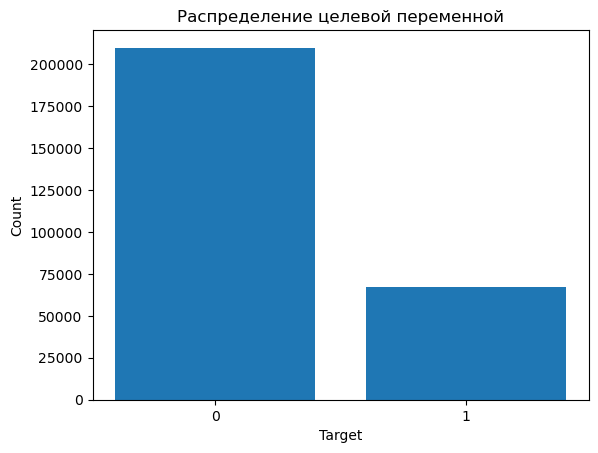

In [33]:
counts = df.target.value_counts()
plt.bar(counts.index, counts.values)
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Распределение целевой переменной')
plt.xticks([0, 1])
plt.show()

Отношение данных в целевом признаке в выборке примерно 2,73:1. Нет необходимости искусственно изменять это соотношение с помощью upsampling, но при разделении данных на train-validation-test надо учесть это соотношение.
 - Выделим признаки и целевой признак.

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277140 entries, 0 to 887371
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   loan_amnt         277140 non-null  float64
 1   int_rate          277140 non-null  float64
 2   installment       277140 non-null  float64
 3   home_ownership    277140 non-null  object 
 4   purpose           277140 non-null  object 
 5   annual_inc_joint  277140 non-null  float64
 6   joint             277140 non-null  int64  
 7   plan              277140 non-null  int64  
 8   new_term          277140 non-null  int64  
 9   grade             277140 non-null  int64  
 10  emplo_lenghth     277140 non-null  int64  
 11  verification      277140 non-null  int64  
 12  target            277140 non-null  int64  
dtypes: float64(4), int64(7), object(2)
memory usage: 29.6+ MB


In [35]:
#выделим целевой признак, категориальные признаки, разобьем на две выборке 1 к 3
features = df.drop('target', axis=1)
target = df['target']

#определим категориальные и числовые признаки
cat_features = ['home_ownership', 'purpose']
interval_cols = df.drop(['home_ownership', 'purpose', 'target'], axis=1).columns.to_list()

#разобьем на две выборки 1 к 3
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, stratify=target, random_state=42)

In [36]:
num_transformer = StandardScaler() #масштабирование численных
cat_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')
cat_transformer_der = OrdinalEncoder(handle_unknown ='use_encoded_value', unknown_value=-1)
num_features = features.drop(cat_features, axis=1).columns.tolist()
#cat_transformer = OneHotEncoder(handle_unknown ='use_encoded_value', unknown_value=-1) #горячее кодирование категориальных, так как их немного

In [37]:
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

preprocessor_forest = ColumnTransformer(transformers=[
    ('num', num_transformer, interval_cols),
    ('cat', cat_transformer_der, cat_features)])

preprocessor_catboost = ColumnTransformer(transformers=[
    ('num', num_transformer, interval_cols)], remainder='passthrough')


In [38]:
forest_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor_forest),
    ('classifier', RandomForestClassifier(random_state=42))])

forest_param= {
    'classifier__n_estimators': [50, 100, 150, 300],
    'classifier__max_depth': [10, 20, 30],
    'classifier__criterion': ['gini', 'entropy', 'log_loss']}

forest_grid = GridSearchCV(forest_pipe, forest_param, cv=3, scoring='accuracy', n_jobs=-1)
forest_grid.fit(features_train, target_train)

print(f'RandomForest лучшие параметры: {forest_grid.best_params_}')
print(f'RandomForest лучшая оценка: {forest_grid.best_score_}')

RandomForest лучшие параметры: {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__n_estimators': 300}
RandomForest лучшая оценка: 0.7607514854105025


RandomForest лучшие параметры: {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__n_estimators': 300}
RandomForest лучшая оценка: 0.7607514854105025

In [ ]:
k_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())])

k_param = {'classifier__n_neighbors': [3, 5, 7, 10],
           'classifier__weights': ['uniform', 'distance'],
           'classifier__metric': ['euclidean', 'manhattan']}

k_grid = GridSearchCV(k_pipe, k_param, cv=3, scoring='accuracy')
k_grid.fit(features_train, target_train)

print(f'KNeighbors лучшие параметры: {k_grid.best_params_}')
print(f'KNeighbors лучшая оценка: {k_grid.best_score_}')

/Users/nataliia/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/nataliia/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/nataliia/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/nataliia/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/nataliia/anaconda3/lib/python3.10/site-packag

KNeighbors лучшие параметры: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 10, 'classifier__weights': 'uniform'}
KNeighbors лучшая оценка: 0.7491953525294076

In [ ]:
catboost = CatBoostClassifier(random_state=42, verbose=False, cat_features=cat_features)

cat_param = {
    'iterations': [50, 100, 200],
    'learning_rate': [0.03, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]}

cat_grid = GridSearchCV(catboost, cat_param, cv=3, error_score='raise', scoring='accuracy', n_jobs=-1)
cat_grid.fit(features_train, target_train)

print(f'CatBoost лучшие параметры: {cat_grid.best_params_}')
print(f'CatBoost лучшая оценка: {cat_grid.best_score_}')

CatBoost лучшие параметры: {'depth': 6, 'iterations': 200, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
CatBoost лучшая оценка: 0.7508209810450647

In [41]:
best_model = forest_grid.best_estimator_

preds = best_model.predict(features_test)
accuracy = accuracy_score(target_test, preds)


probabilities_test = best_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(f'Точность на тестовой выборке: {accuracy:.4f}')
print(f'ROC-AUC лучшей модели: {auc_roc:.4f}')

Точность на тестовой выборке: 0.7619
ROC-AUC лучшей модели: 0.6998


Точность на тестовой выборке: 0.7619
ROC-AUC лучшей модели: 0.6998

In [46]:
feature_importances = best_model._final_estimator.feature_importances_
feature_names = features.columns


importance_df = pd.DataFrame({
    'Features': feature_names,
    'Importance': feature_importances
})


importance_df = importance_df.sort_values(by='Importance', ascending=False)


importance_df.reset_index(drop=True, inplace=True)


display(importance_df)

,Features,Importance
0,plan,0.316962
1,int_rate,0.260735
2,home_ownership,0.115602
3,joint,0.101100
4,installment,0.068500
5,loan_amnt,0.062240
6,new_term,0.029936
7,emplo_lenghth,0.023116
8,verification,0.021606
9,annual_inc_joint,0.000103


Проверим гипотезы:

1. Гипотеза о том, что лица с более высоким доходом имеют меньший риск кредитного дефолта.
2. Заемщики, владеющие собственным жильем(предлагаю собственным жильем считать MORTGAGE и OWN), имеют более низкий риск кредитного дефолта.
3. Заемщики, имеющие более высокий кредитный рейтинг, имеют меньшую вероятность кредитного дефолта, чем лица с низким кредитным рейтингом.
4. Проверка на различие размера кредита у двух групп

In [47]:
from scipy.stats import chi2_contingency, ttest_ind

# Гипотеза №1
high_income = df[df['annual_inc_joint'] > df['annual_inc_joint'].median()]['target']
low_income = df[df['annual_inc_joint'] <= df['annual_inc_joint'].median()]['target']

t_stat, p_val = ttest_ind(high_income, low_income)
print('Гипотеза 1: P-значение:', p_val)

Гипотеза 1: P-значение: 4.296426008585372e-306


Гипотеза 1: P-значение: 0.0

In [48]:
# Гипотеза №2
own_home = df[df['home_ownership'].isin(['MORTGAGE', 'OWN'])]['target']
not_own_home = df[~df['home_ownership'].isin(['MORTGAGE', 'OWN'])]['target']

# категориальные признаки, поэтому используем chi2
chi2, p_val, dof, ex = chi2_contingency(pd.crosstab(df['home_ownership'].isin(['MORTGAGE', 'OWN']), df['target']))

print('Гипотеза 2: P-значение:', p_val)

Гипотеза 2: P-значение: 1.1306737082436108e-151


Гипотеза 2: P-значение: 1.6598126115285543e-219

In [49]:
# Гипотеза №3
# Разделяем данные на две группы: заемщики с высоким и низким рейтингом
high_grade = df[df["grade"] >= df["grade"].median()]["target"]
low_grade = df[df["grade"] < df["grade"].median()]["target"]

# Применяем t-тест Стьюдента
t_stat, p_val = ttest_ind(high_grade, low_grade)

# Выводим результаты
print('Гипотеза 3: P-значение:', p_val)

Гипотеза 3: P-значение: 0.0


Гипотеза 3: P-значение: 0.0

P-значение меньше 0.05 говорит о том, что мы можем отвергнуть нулевые гипотезы (о равенстве средних или независимости в случае категориальных переменных)

In [50]:
# Гипотеза №4
from scipy import stats as st

sample_1 = df[df['target']==1]['loan_amnt']
sample_2 = df[df['target']==0]['loan_amnt']

alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(sample_1, sample_2, equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу,  средний размер двух ген совокупнсотей (с риском и без) различен')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.0
Отвергаем нулевую гипотезу,  средний размер двух ген совокупнсотей (с риском и без) различен
